In [6]:
def QML_Classification(Dataset, Features, Labels):
    
    from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
    from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
    from qiskit.primitives import Sampler
    import time
    from qiskit_machine_learning.algorithms.classifiers import VQC
    from sklearn.model_selection import train_test_split
    from qiskit_algorithms.utils import algorithm_globals
    from sklearn.preprocessing import MinMaxScaler
    from matplotlib import pyplot as plt
    from IPython.display import clear_output
    import numpy
    from qiskit.circuit import Parameter
    from qiskit import QuantumCircuit

    
    features = Features  # this need to be properly defined, if your data is not in data and label form split 
    labels = Labels  # it into arrays change this features and label to make it two diff arrays
    features = MinMaxScaler().fit_transform(features)
    
    algorithm_globals.random_seed = numpy.random.randint(100,10000)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, train_size=0.7, random_state=algorithm_globals.random_seed
    )

    num_features = features.shape[1]

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    feature_map.decompose()
    
    def Ansatz_housing(num_features):
        ansatz_custom = QuantumCircuit(num_features)
        j = 0
        for i in range(num_features):
            ansatz_custom.ry(Parameter('θ_' +str(j)), i)
            j += 1
            ansatz_custom.rz(Parameter('θ_' +str(j)), i)
            j += 1
        ansatz_custom.barrier()
        
        ansatz_custom.cx(0,1)
        ansatz_custom.cx(0,3)
        ansatz_custom.cx(0,4)
        ansatz_custom.cx(0,9)
        ansatz_custom.cx(0,10)
        ansatz_custom.cx(2,4)
        ansatz_custom.cx(2,3)
        ansatz_custom.cx(7,6)
        ansatz_custom.barrier()
        
        for i in range(num_features):
            ansatz_custom.ry(Parameter('θ_' +str(j)), i)
            j += 1
            ansatz_custom.rz(Parameter('θ_' +str(j)), i)
            j += 1
        return ansatz_custom 
    
    ansatz = Ansatz_housing(num_features) #RealAmplitudes(num_qubits=num_features, reps=2)
    #ansatz.decompose()
    
    
    optimizer = COBYLA(maxiter=200)
    sampler = Sampler()
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    
    def callback_graph(weights, obj_func):
        clear_output(wait=True)
        objective_func_vals.append(obj_func)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()
        
    vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    )
    
    objective_func_vals = []
    start = time.time()
    vqc.fit(train_features, train_labels)
    elapsed = time.time() - start
    
    print(f"Training time: {round(elapsed)} seconds")
    
    train_score = vqc.score(train_features, train_labels)
    test_score = vqc.score(test_features, test_labels)
    from sklearn.metrics import mean_squared_error, r2_score
    
    pred_train_features = vqc.predict(train_features)
    pred_test_features = vqc.predict(test_features)

    train_mse = mean_squared_error(train_labels, pred_train_features)
    test_mse = mean_squared_error(test_labels, pred_test_features)
    train_r2 = r2_score(train_labels, pred_train_features)
    test_r2 = r2_score(test_labels, pred_test_features)
    
    from sklearn import metrics
    confusion_matrix = metrics.confusion_matrix(train_labels, pred_train_features)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    
    print("algorithm_globals.random seed =", algorithm_globals.random_seed)
    print("Train Score = ",train_score) 
    print("Test Score = ",test_score)
    print("Train Mean Squared Error = ",train_mse) 
    print("Test Mean Squared Error = ",test_mse)
    print("Train r2 Score = ",train_r2) 
    print("Test r2 Score = ",test_r2)

    cm_display.plot()
    display(feature_map.decompose().draw('mpl'))
    display(ansatz.draw('mpl'))
     
    plt.show()
    print(vqc.predict([[6231, 3, 2, 2, 0, 1, 0, 1, 1, 1, 0, 1], [9256, 4, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0], [4006, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1], [7150, 4, 2, 3, 0, 1, 0, 1, 1, 2, 0, 2]]))
    


In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
%matplotlib inline

In [8]:
house = pd.read_csv('Housing.csv')
house

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [9]:
house['airconditioning'] = house['airconditioning'].map({'yes': 1, 'no': 0})
house['mainroad'] = house['mainroad'].map({'yes': 1, 'no': 0})
house['guestroom'] = house['guestroom'].map({'yes': 1, 'no': 0})
house['basement'] = house['basement'].map({'yes': 1, 'no': 0})
house['hotwaterheating'] = house['hotwaterheating'].map({'yes': 1, 'no': 0})
house['prefarea'] = house['prefarea'].map({'yes': 1, 'no': 0})
house['furnishingstatus'] = house['furnishingstatus'].map({'furnished': 2, 'unfurnished': 0, 'semi-furnished': 1})
house

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,2


<Axes: >

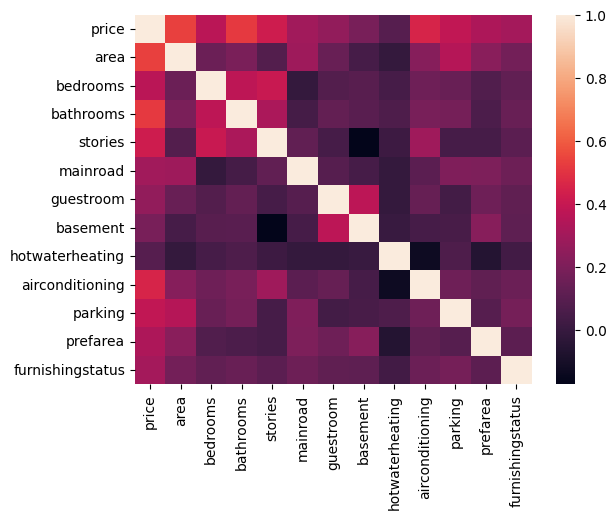

In [10]:
sns.heatmap(house.corr())

In [11]:
lab = []
for i in range(len(house['price'])):
    if house['price'][i] <= 4000000:
        lab.append(-1)
    else :
        lab.append(1)
print(lab)
        

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -

In [12]:
house['label'] = np.array(lab)
house = house.sample(frac = 1) #shuffle rows
house

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,label
125,5943000,15600,3,1,1,1,0,0,0,1,2,0,1,1
169,5250000,6540,4,2,2,0,0,0,0,1,0,0,1,1
144,5600000,4700,4,1,2,1,1,1,0,1,1,0,2,1
494,2730000,6800,2,1,1,1,0,0,0,0,0,0,0,-1
197,4956000,2800,3,2,2,0,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,5243000,6050,3,1,1,1,0,1,0,0,0,1,1,1
34,8120000,6840,5,1,2,1,1,1,0,1,1,0,2,1
299,4200000,7000,3,1,1,1,0,0,0,0,3,0,2,1
279,4270000,6360,2,1,1,1,0,0,0,0,0,0,2,1


In [13]:
data = house.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].values
target_price = house.iloc[:, 0].values
price_label = house.iloc[:, 13].values
Dict = {'data' : data, 'target_price' : target_price, 'price_label' : price_label}

Features = Dict['data']
Labels = Dict['price_label']  # This is for classification

Target = Dict['price_label']  # This only for Regression
data

array([[15600,     3,     1, ...,     2,     0,     1],
       [ 6540,     4,     2, ...,     0,     0,     1],
       [ 4700,     4,     1, ...,     1,     0,     2],
       ...,
       [ 7000,     3,     1, ...,     3,     0,     2],
       [ 6360,     2,     1, ...,     0,     0,     2],
       [16200,     5,     3, ...,     0,     0,     0]], dtype=int64)

### Don't Disturb This Cell, here maxiteration is 200. 

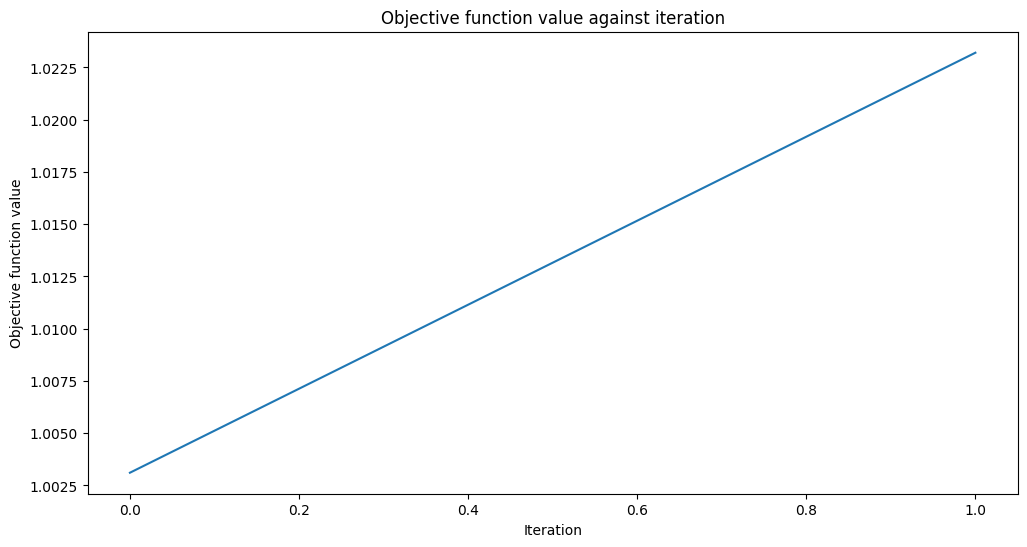

KeyboardInterrupt: 

In [16]:
QML_Classification(Dict, Features, Labels) 

### Don't Disturb This Cell, here maxiteration is 200 with EfficientSU2 Anstaz.


In [ ]:
QML_Classification(Dict, Features, Labels) #

In [ ]:
QML_Classification(Dict, Features, Labels) #